# GANS Example

Source code [here](https://pyimagesearch.com/2020/11/16/gans-with-keras-and-tensorflow/) and [here](https://github.com/margaretmz/GANs-in-Art-and-Design#1-intro-to-gans)

## GAN Training Challenges: DCGAN for Color Images

In [ ]:
import os

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


print(tf.version.VERSION)

2.12.0


### Config Dataset download with kaggle

In [ ]:
os.environ['KAGGLE_USERNAME']="scorrea92"
os.environ['KAGGLE_KEY']="6e119661d8b37fa8fa2fc86269a2d054"

# download kaggle dataset to 'datasets/' path
!kaggle datasets download -d dqmonn/zalando-store-crawl -p datasets
!unzip datasets/zalando-store-crawl.zip -d datasets/
zalando_data_dir = "/content/datasets/zalando/zalando"

# Get Dataset
train_images = tf.keras.utils.image_dataset_from_directory(
    zalando_data_dir, label_mode=None, image_size=(64, 64), batch_size=32
)

### Visualization

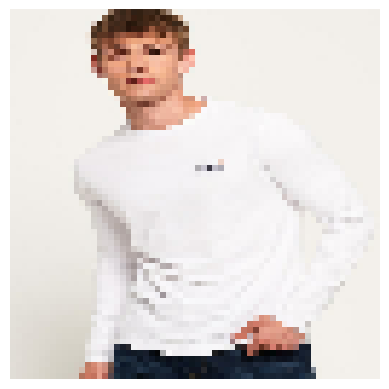

In [ ]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

### Preprocessing

In [ ]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

### The Generator

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 64x64x3.

In [ ]:
# latent dimension of the random noise
LATENT_DIM = 100
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1

def build_generator():
    # create a Keras Sequential model
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [ ]:
# build the generator model
generator = build_generator()

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


### The Discriminator

Define the discriminator model architecture with the Keras `Sequential` APIç

In [ ]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [ ]:
# build the discriminator model
discriminator = build_discriminator(64, 64, 3)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

### Define the DCGAN class

Subclass keras.Model and override train_step() to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation.

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0)
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

### Use Keras Callback to monitor training

The nice thing about overriding train_step() of keras.Model() is that we can subclass Callback to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to see the progress of the generator is making. Also saved the generator model at the end of the training which could potentially be used for inference later.

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

### The DCGAN model - putting it together

In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

#### Compile DCGAN
Compile the dcgan model, use the Adam optimizer, learning rate of 0.0002, and the Binary Cross Entropy as recommended by the paper.

In later GAN tutorials, you will learn that we can use other loss functions for other GAN variants.

In [ ]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

#### Train DCGAN

In [ ]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

Output hidden; open in https://colab.research.google.com to view.

# WGAN Example

Source code [here](https://github.com/margaretmz/GANs-in-Art-and-Design#1-intro-to-gans)

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

print(tf.version.VERSION)

2.12.0


### Data Preparation

In [3]:
os.environ['KAGGLE_USERNAME']="scorrea92"
os.environ['KAGGLE_KEY']="6e119661d8b37fa8fa2fc86269a2d054"

# download kaggle dataset to 'datasets/' path
!kaggle datasets download -d splcher/animefacedataset -p datasets
!unzip datasets/animefacedataset.zip -d datasets/
anime_data_dir = "/content/datasets/images"

# Get Dataset
train_images = tf.keras.utils.image_dataset_from_directory(
    anime_data_dir, label_mode=None, image_size=(64, 64), batch_size=256 # update from 32
)

Streaming output truncated to the last 5000 lines.
  inflating: datasets/images/62765_2019.jpg  
  inflating: datasets/images/62766_2019.jpg  
  inflating: datasets/images/62767_2019.jpg  
  inflating: datasets/images/62768_2019.jpg  
  inflating: datasets/images/62769_2019.jpg  
  inflating: datasets/images/6276_2003.jpg  
  inflating: datasets/images/62770_2019.jpg  
  inflating: datasets/images/62771_2019.jpg  
  inflating: datasets/images/62772_2019.jpg  
  inflating: datasets/images/62773_2019.jpg  
  inflating: datasets/images/62774_2019.jpg  
  inflating: datasets/images/62775_2019.jpg  
  inflating: datasets/images/62776_2019.jpg  
  inflating: datasets/images/62777_2019.jpg  
  inflating: datasets/images/62778_2019.jpg  
  inflating: datasets/images/62779_2019.jpg  
  inflating: datasets/images/6277_2003.jpg  
  inflating: datasets/images/62780_2019.jpg  
  inflating: datasets/images/62781_2019.jpg  
  inflating: datasets/images/62782_2019.jpg  
  inflating: datasets/images/62

### Visualization

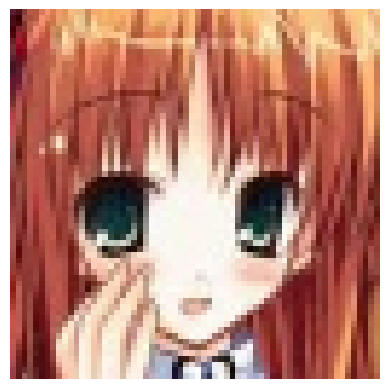

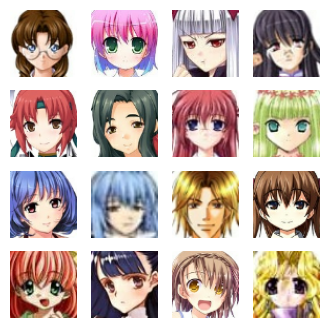

In [4]:
def show(images):
  # Function for ploting multiple images x16 images
    plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = keras.utils.array_to_img(images[i])
        plt.imshow(img)
        plt.axis('off')
    plt.show()

image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")

# Visualize 1 random image from the training dataset
plt.axis("off")
plt.imshow(random_image)
plt.show()

# Visualize 16 images from the training dataset
show(image_batch[:32])

### Preprocessing

In [5]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

### The Generator

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images: we feed random noise as input to the generator and upsample it till the desired image size becomes 64x64x3.

In [6]:
# latent dimension of the random noise
LATENT_DIM = 128
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=0)
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3

def build_generator():
    # create a Keras Sequential model
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4),
                                     strides=(2, 2),
                                     padding="same",
                                     use_bias=False,
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4),
                                     strides=(2, 2),
                                     padding="same",
                                     use_bias=False,
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4),
                                     strides=(2, 2),
                                     padding="same",
                                     use_bias=False,
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

# build the generator model
generator = build_generator()

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             4227072   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097152   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0 

### The Critic
In WGAN we have a critic instead of a discriminator.
If you are updating a DCGAN to a WGAN, you can use the “Find and replace” in Colab for the updates.

In [7]:
# UPDATE for WGAN: a new class implementing weight clipping constraint
class WeightClipping(tf.keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value

    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

    def get_config(self):
        return {'clip_value': self.clip_value}


def build_critic(height, width, depth, alpha=0.2):
    #UPDATE for WGAN: enfoce 1-Lipschitz constraint with weight clippping to [-1, 1]
    constraint = WeightClipping(0.01)

    # create a Keras Sequential model
    model = Sequential(name="critic")
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same",
                            strides=(2, 2),
                            kernel_constraint = constraint, # UPDATE for WGAN
                            input_shape=input_shape))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same",
                            strides=(2, 2),
                            kernel_constraint = constraint,)) # UPDATE for WGAN
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same",
                            strides=(2, 2),
                            kernel_constraint = constraint,)) # UPDATE for WGAN
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # UPDATE for WGAN: linear activation in the last layer.
    # Note: Keras `Dense` layer by default is already a `linear` activation
    model.add(layers.Dense(1, activation="linear"))

    # return the critic model
    return model

# build the critic model
critic = build_critic(64, 64, 3)

critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0    

### WGAN

Subclass keras.Model to implement WGAN and override train_step() to implement custom training steps for training the critic and generator in WGAN.

In [8]:
class WGAN(keras.Model):
    def __init__(self,
                 critic,
                 generator,
                 latent_dim,
                 critic_extra_steps): # UPDATE
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.c_extra_steps = critic_extra_steps
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # UPDATE for WGAN: remove the code of real / fake labels
    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # UPDATE for WGAN: we train the critic more often than the generator by 5 times (self.c_extra_steps)
        for i in range(self.c_extra_steps):
            # Step 1. Train the critic with both real images and fake images
            with tf.GradientTape() as tape:
                # Get the critic' predictions on the real images
                pred_real = self.critic(real_images, training=True)
                # Generate fake images from the latent noise
                fake_images = self.generator(noise, training=True)
                # Get the critic' predictions on the fake images
                pred_fake = self.critic(fake_images, training=True)
                # Calculate the critic loss with wassertein loss function
                d_loss = self.d_loss_fn(pred_real, pred_fake)
            # Compute critic gradients
            grads = tape.gradient(d_loss, self.critic.trainable_variables)
            # Update critic weights
            self.d_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        # Step 2. Train the generator (do not update weights of the critic)
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.critic(fake_images, training=True)
            g_loss = self.g_loss_fn(pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()
        show(generated_images)

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

## Compile and Train WGAN

Compile the `wgan` model with the `RMSprop` optimizer (a learning rate of 0.00005) as recommended by the paper, and the **Wasserstein loss**

#### Putting together the `wgan` model

In [9]:
wgan = WGAN(
  critic=critic,
  generator=generator,
  latent_dim=LATENT_DIM,
  critic_extra_steps=5 # UPDATE for WGAN
)

#### Wasserstein loss

In [10]:
# Wasserstein loss for the critic
def d_wasserstein_loss(pred_real, pred_fake):
    real_loss = tf.reduce_mean(pred_real)
    fake_loss = tf.reduce_mean(pred_fake)
    return fake_loss - real_loss

# Wasserstein loss for the generator
def g_wasserstein_loss(pred_fake):
    return -tf.reduce_mean(pred_fake)

#### Compile

In [11]:
LR = 0.00005 # UPDATE for WGAN: learning rate per WGAN paper
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR,
    decay_steps=100000,
    decay_rate=0.9)

wgan.compile(
    d_optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule, clipvalue=1.0), # UPDATE for WGAN: use RMSProp instead of Adam
    g_optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule, clipvalue=1.0), # UPDATE for WGAN: use RMSProp instead of Adam
    d_loss_fn = d_wasserstein_loss,
    g_loss_fn = g_wasserstein_loss
)

### Train WGAN

Epoch 1/50
249/249 [==============================] - ETA: 0s - d_loss: -9.2791 - g_loss: 5.6793

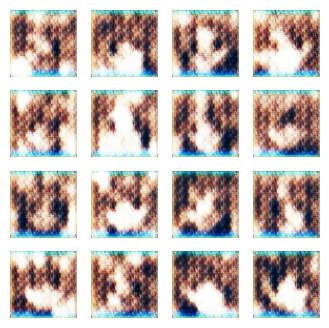

249/249 [==============================] - 329s 1s/step - d_loss: -9.2791 - g_loss: 5.6793
Epoch 2/50
249/249 [==============================] - ETA: 0s - d_loss: -40.7397 - g_loss: 30.4840

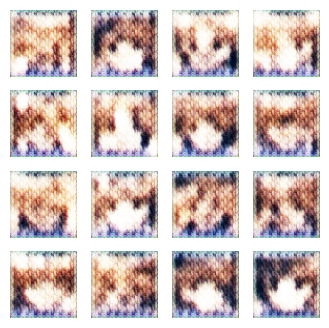

249/249 [==============================] - 301s 1s/step - d_loss: -40.7397 - g_loss: 30.4840
Epoch 3/50
249/249 [==============================] - ETA: 0s - d_loss: -82.9907 - g_loss: 63.9674

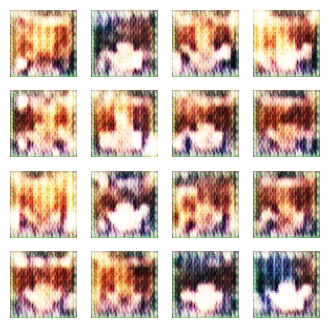

249/249 [==============================] - 301s 1s/step - d_loss: -82.9907 - g_loss: 63.9674
Epoch 4/50
249/249 [==============================] - ETA: 0s - d_loss: -129.4141 - g_loss: 92.1907

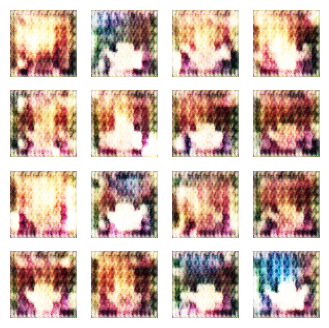

249/249 [==============================] - 301s 1s/step - d_loss: -129.4141 - g_loss: 92.1907
Epoch 5/50
249/249 [==============================] - ETA: 0s - d_loss: -166.3955 - g_loss: 105.1111

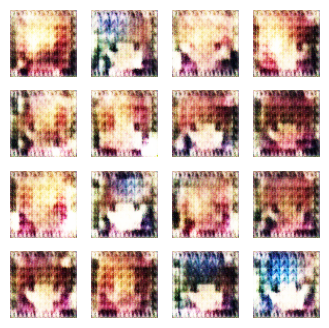

249/249 [==============================] - 300s 1s/step - d_loss: -166.3955 - g_loss: 105.1111
Epoch 6/50
249/249 [==============================] - ETA: 0s - d_loss: -200.9833 - g_loss: 114.2838

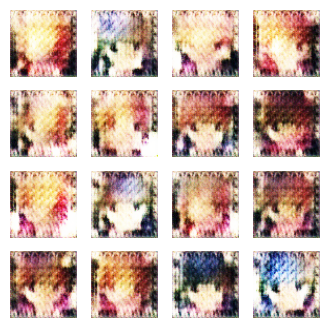

249/249 [==============================] - 300s 1s/step - d_loss: -200.9833 - g_loss: 114.2838
Epoch 7/50
 71/249 [=======>......................] - ETA: 3:33 - d_loss: -216.3419 - g_loss: 129.8741

KeyboardInterrupt: ignored

In [12]:
NUM_EPOCHS = 50 # number of epochs
wgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

## Compile and Train WGAN-DP


### The Critic

In [13]:
def build_critic(height, width, depth, alpha=0.2):
    # Weight clipping to [-1, 1] to enfoce 1-Lipschitz constraint
    # constraint = WeightClip(0.01) # UPDATE for WGAN-GP: remove weight clipping

    # create a Keras Sequential model
    model = Sequential(name="critic")
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4),
                            padding="same",
                            strides=(2, 2),
                            # kernel_constraint = constraint, # UPDATE for WGAN-GP: remove weight clipping
                            input_shape=input_shape))
    # model.add(layers.BatchNormalization()) # UPDATE for WGAN-GP: remove batchnorm
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4),
                            padding="same",
                            strides=(2, 2)))
                            # kernel_constraint = constraint,)) # UPDATE for WGAN-GP: remove weight clipping
    # model.add(layers.BatchNormalization()) # UPDATE for WGAN-GP: remove batchnorm
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4),
                            padding="same",
                            strides=(2, 2)))
                            # kernel_constraint = constraint,)) # UPDATE for WGAN-GP: remove weight clipping
    # model.add(layers.BatchNormalization()) # UPDATE for WGAN-GP: remove batchnorm
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # linear activation in the last layer
    # Note: Keras `Dense` layer by default is already a `linear` activation
    model.add(layers.Dense(1, activation="linear"))

    # return the critic model
    return model

# build the critic model
critic = build_critic(64, 64, 3)
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0    

### WGAN-GP
Subclass keras.Model to implement WGAN-GP and override train_step() to implement custom training steps for training the critic and generator in WGAN-GP.

In [14]:
class WGAN_GP(keras.Model):
    def __init__(self,
                 critic,
                 generator,
                 latent_dim,
                 critic_extra_steps,
                 gp_weight=10.0): # UPDATE for WGAN-GP: gradient penalty weight
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.c_extra_steps = critic_extra_steps
        self.gp_weight = gp_weight # WGAN-GP
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")


    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN_GP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # UPDATE for WGAN-GP: use gradient penalty instead of weight clipping
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        Gradient penalty is calculated on an interpolated image
        and added to the discriminator loss.
        """

        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        # 1. Create the interpolated image
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 2. Get the Critic's output for the interpolated image
            pred = self.critic(interpolated, training=True)

        # 3. Calculate the gradients w.r.t to the interpolated image
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 4. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        # 5. Calculate gradient penalty
        gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
        return gradient_penalty

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the critic more often than the generator by 5 times (self.c_extra_steps)
        for i in range(self.c_extra_steps):
            # Step 1. Train the critic with both real images and fake images
            with tf.GradientTape() as tape:
                pred_real = self.critic(real_images, training=True)
                fake_images = self.generator(noise, training=True)
                pred_fake = self.critic(fake_images, training=True)
                # UPDATE for WGAN-GP: Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # UPDATE for WGAN-GP: Add gradient penalty to the original critic loss
                d_loss = self.d_loss_fn(pred_real, pred_fake) + gp * self.gp_weight
            # Compute critic gradients
            grads = tape.gradient(d_loss, self.critic.trainable_variables)
            # Update critic weights
            self.d_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        # Step 2. Train the generator (do not update weights of the critic)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.critic(fake_images, training=True)
            g_loss = self.g_loss_fn(pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

### Use Keras Callback to monitor training
The nice thing about overriding train_step() of keras.Model() is that we can subclass Callback to monitor our WGAN-GP training.

I use the seed noise to create images (with the generator model) throughout the training to see the progress of the generator is making. Also saved the generator model at the end of the training which could potentially be used for inference later.

In [15]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

### Compile and Train WGAN-GP
Compile the wgan-gp model, use the Adam optimizer as recommended by the WGAN-GP paper, and the Wasserstein loss same as in WGAN.

Putting together the wgan-gp model

In [16]:
wgan_gp = WGAN_GP(
    critic=critic,
    generator=generator,
    latent_dim=LATENT_DIM,
    critic_extra_steps=5
)

In [17]:
LR = 0.0002 # WGAN-GP paper recommends lr of 0.0002
d_optimizer = keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.9) # UPDATE for WGAN-GP: use Adam instead of RMSProp
g_optimizer = keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.9) # UPDATE for WGAN-GP: use Adam instead of RMSProp

wgan_gp.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    d_loss_fn = d_wasserstein_loss,
    g_loss_fn = g_wasserstein_loss
)

### Train WGAN-GP
Now we simply call model.fit() to traing the wgan-gp model!

Epoch 1/50
249/249 [==============================] - ETA: 0s - d_loss: -15.6240 - g_loss: -6.8234

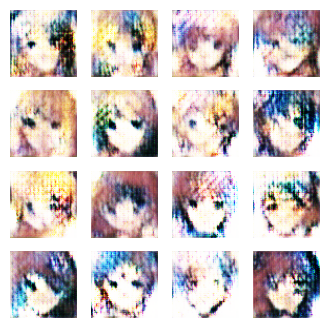

249/249 [==============================] - 393s 2s/step - d_loss: -15.6240 - g_loss: -6.8234
Epoch 2/50
249/249 [==============================] - ETA: 0s - d_loss: -11.0446 - g_loss: -8.0046

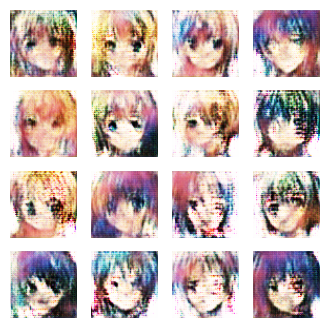

249/249 [==============================] - 379s 2s/step - d_loss: -11.0446 - g_loss: -8.0046
Epoch 3/50
249/249 [==============================] - ETA: 0s - d_loss: -8.2037 - g_loss: -5.4338

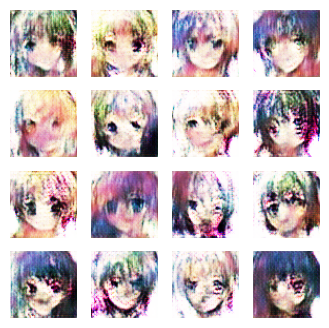

249/249 [==============================] - 379s 2s/step - d_loss: -8.2037 - g_loss: -5.4338
Epoch 4/50
249/249 [==============================] - ETA: 0s - d_loss: -6.9060 - g_loss: 0.1771

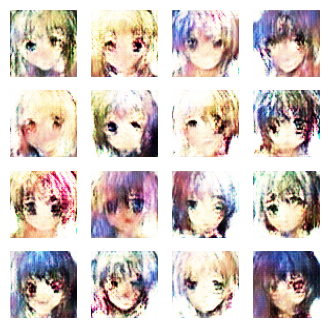

249/249 [==============================] - 379s 2s/step - d_loss: -6.9060 - g_loss: 0.1771
Epoch 5/50
249/249 [==============================] - ETA: 0s - d_loss: -6.1695 - g_loss: 2.5145

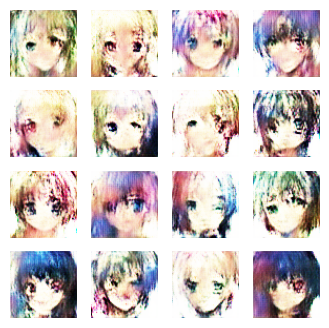

249/249 [==============================] - 379s 2s/step - d_loss: -6.1695 - g_loss: 2.5145
Epoch 6/50
249/249 [==============================] - ETA: 0s - d_loss: -5.6005 - g_loss: -2.2718

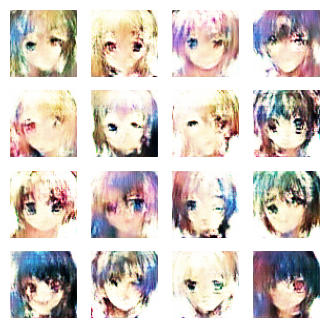

249/249 [==============================] - 379s 2s/step - d_loss: -5.6005 - g_loss: -2.2718
Epoch 7/50
241/249 [============================>.] - ETA: 12s - d_loss: -5.2980 - g_loss: 1.6897

In [ ]:
NUM_EPOCHS = 50 # number of epochs
wgan_gp.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])